In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


## How to compute survival Radius

This only works right now for the simplified case of collisional ionization equilibrium

In [2]:
import numpy as np
import unyt
from cholla_cooling import ChollaEOS
from estimate_survival_radius import estimate_survival_radius

cholla_cie_eos = ChollaEOS()

# you can specify the cloud temperature
r_crit_a = estimate_survival_radius(
    eos = cholla_cie_eos, vwind = 100*unyt.km/unyt.s,
    density_contrast = 100, alpha = 7,
    pressure = 1e3 * unyt.K/unyt.cm**3 * unyt.kboltz_cgs,
    temperature_cl = unyt.unyt_quantity(1e4, 'K'))

print('\n Critical Survival Radius:', r_crit_a)


 Critical Survival Radius: 5.159660070930516 pc


In [3]:
# you can specify the wind temperature
r_crit_b = estimate_survival_radius(
    eos = cholla_cie_eos, vwind = 100*unyt.km/unyt.s,
    density_contrast = 100, alpha = 7,
    pressure = 1e3 * unyt.K/unyt.cm**3 * unyt.kboltz_cgs,
    temperature_w = unyt.unyt_quantity(1e6, 'K'))

print('Critical Survival Radius:', r_crit_b)

# it's good that the results are pretty much the same!

Critical Survival Radius: 5.159660070930513 pc


## Sanity-Check: looking at $\chi$-dependence

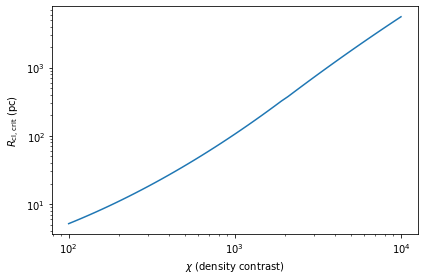

In [4]:
chi_vals = np.geomspace(1e2, 1e4, num = 51)
rcrit_vals = []
for chi in chi_vals:
    rcrit_vals.append(estimate_survival_radius(
        eos = cholla_cie_eos, vwind = 100*unyt.km/unyt.s,
        density_contrast = chi, alpha = 7,
        pressure = 1e3 * unyt.K/unyt.cm**3 * unyt.kboltz_cgs,
        temperature_cl = unyt.unyt_quantity(1e4, 'K')
    ))
    
fig,ax = plt.subplots(1,1)
ax.loglog(chi_vals, rcrit_vals)
ax.set_xlabel(r'$\chi$ (density contrast)')
ax.set_ylabel(r'$R_{\rm cl,crit}$ (pc)')
fig.tight_layout()

## Comparing different cooling functions
I'm not presently sure how to explain the discrepancy between the Cholla cooling curves and the Grackle cooling functions.

In [5]:
cholla_cie_eos = ChollaEOS()
cholla_cloudy_eos = ChollaEOS(
    cloudy_data_path = ('/home/mabruzzo/hydro/cholla/src/cooling/'
                        'cloudy_coolingcurve.txt')
)

def load_grackle_eos():
    from gascloudtool.eos import GrackleEOS
    return GrackleEOS.build_default_eos(
        density_units = float(unyt.mh_cgs.v), # equivalent to number density of 1 cm^3
                                              # of neutral hydrogen
        length_units = float(unyt.unyt_quantity(1.0, 'pc').to('cm').v),
        time_units = float(unyt.unyt_quantity(100.0, 'kyr').to('s').v),
    )

/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/unyt/array.py:1779: RuntimeWarning: divide by zero encountered in true_divide
  inp0.view(np.ndarray), inp1.view(np.ndarray), out=out_func, **kwargs
/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/unyt/array.py:1779: RuntimeWarning: divide by zero encountered in true_divide
  inp0.view(np.ndarray), inp1.view(np.ndarray), out=out_func, **kwargs
/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/unyt/array.py:1779: RuntimeWarning: divide by zero encountered in true_divide
  inp0.view(np.ndarray), inp1.view(np.ndarray), out=out_func, **kwargs
/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/unyt/array.py:1779: RuntimeWarning: divide by zero encountered in true_divide
  inp0.view(np.ndarray), inp1.view(np.ndarray), out=out_func, **kwargs
/home/mabruzzo/.pyenv/versions/3.7.2/envs/py37_new/lib/python3.7/site-packages/unyt/arra

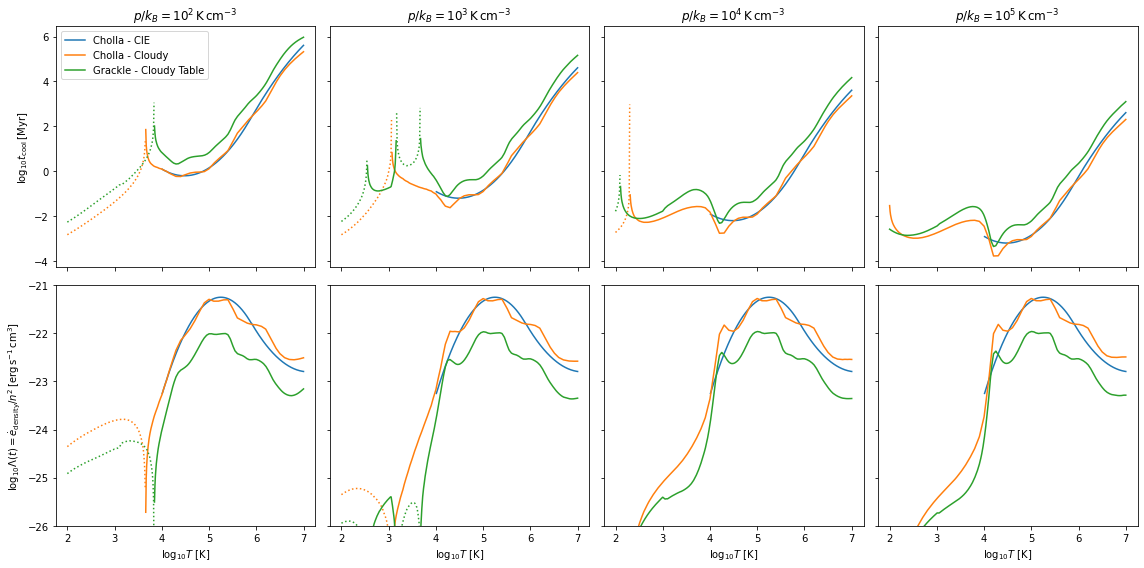

In [6]:
import functools

def _plot_tcool(ax, T_vals, cool_val, label = None, color = None):
    log_cool_val = np.empty_like(cool_val)
    w = cool_val < 0
    log_cool_val[w] = np.log10(-1*cool_val[w])
    log_cool_val[~w] = np.inf

    kw = {}
    if label is not None:
        kw['label'] = label
    if color is not None:
        kw['color'] = color
    ax.plot(np.log10(T_vals), log_cool_val, **kw)
    log_heat_val = np.empty_like(cool_val)
    w = cool_val > 0
    log_heat_val[w] = np.log10(cool_val[w])
    log_heat_val[~w] = np.inf
    kw = {}
    if color is not None:
        kw['color'] = color
    ax.plot(np.log10(T_vals), log_heat_val, ls = ':', **kw)
    
def _rho_eint_vals(eos, T_min, T_max, pressure, num):
    assert T_min < T_max
    
    n_min = pressure / (unyt.kboltz_cgs * T_min)
    n_max = pressure / (unyt.kboltz_cgs * T_max)

    # we are bending over backwards here to do this calculation
    # in terms of specific internal energy so we can make
    # comparisons with Grackle
    _, eint_min = eos.rho_eint_from_nT(n_min, T_min)
    _, eint_max = eos.rho_eint_from_nT(n_max, T_max)
    
    eint_vals = np.geomspace(eint_min, eint_max, num = num)
    eint_vals = unyt.unyt_array(eint_vals, eint_min.units)
    inv_gm1 = 1.0 / (eos.get_gamma() - 1.0)
    rho_vals = pressure * inv_gm1 / eint_vals
    return rho_vals, eint_vals

def plot_tcool(ax, eos, T_min, T_max, pressure, num = 501,
               color = None, label = None):
    rho_vals, eint_vals = _rho_eint_vals(eos, T_min, T_max, pressure,
                                         num = num)
    T_vals = eos.calculate_T(rho_vals, eint_vals)    
    tcool = unyt.unyt_array(eos.calculate_tcool(rho_vals, eint_vals), 's')
    _plot_tcool(ax, T_vals, tcool.to('Myr').v, label = label, color = color)
    
def plot_Lambda(ax, eos, T_min, T_max, pressure, num = 501,
                color = None, label = None, HMassFrac_for_nH = None):
    # divide by number-density squared (not nH squared)
    rho_vals, eint_vals = _rho_eint_vals(eos, T_min, T_max, pressure,
                                         num = num)
    T_vals = eos.calculate_T(rho_vals, eint_vals)    
    tcool = unyt.unyt_array(eos.calculate_tcool(rho_vals, eint_vals), 's')
    edens_vals = rho_vals * eint_vals

    if HMassFrac_for_nH is None:
        ndens_vals = pressure/(unyt.kboltz_cgs * T_vals)
    else:
        ndens_vals = HMassFrac_for_nH * rho_vals / unyt.mh_cgs

    edensdot = (edens_vals / tcool) / (ndens_vals**2)

    _plot_tcool(ax, T_vals, edensdot.to('erg*cm**3/s').v, label = label, color = color)

#def plot_lambda(ax, eos,)


def make_plot(include_grackle = False, divide_by_nH = False):
    fig,ax_arr = plt.subplots(2,4, figsize = (16,8), sharex = True, sharey = 'row')
    
    # using a very approximate HMassFrac in each case
    eos_l = [(cholla_cie_eos, 'Cholla - CIE', 0.76),
             (cholla_cloudy_eos, 'Cholla - Cloudy', 0.76)]
    if include_grackle:
        eos_l.append((load_grackle_eos(), 'Grackle - Cloudy Table', 0.715))

    for i, phat_power in enumerate([2,3,4,5]):
        kwargs = dict(
            T_min = 1e2 * unyt.K, T_max = 1e7 * unyt.K, num = 501,
            pressure = unyt.unyt_quantity(10.0**phat_power,'K/cm**3') * unyt.kboltz_cgs,)
        
        for j in range(2):
            for k, (eos, label, HMassFrac) in enumerate(eos_l):
                color = f'C{k}'

                if j == 0:
                    plot_fn = plot_tcool
                else:
                    if divide_by_nH:
                        HMassFrac_for_nH = HMassFrac
                    else:
                        HMassFrac_for_nH = None
                    plot_fn = functools.partial(plot_Lambda,
                                                HMassFrac_for_nH = HMassFrac_for_nH)
                plot_fn(ax_arr[j,i], eos, color = color, label = label,
                        **kwargs)

    

        ax_arr[0,i].set_title(r'$p/k_B = 10^{' + str(phat_power) +
                              r'}\, {\rm K}\, {\rm cm}^{-3}$')
        ax_arr[1,i].set_xlabel(r'$\log_{10} T$ [K]')

    ax_arr[0,0].set_ylabel(r'$\log_{10} t_{\rm cool}\, $[Myr]')
    denom = r'n_{\rm H}^2' if divide_by_nH else r'n^2'
    ax_arr[1,0].set_ylabel(r'$\log_{10} \Lambda(t) = \dot{e}_{\rm density}/' +
                           denom + 
                           r'\, $[${\rm erg}\, {\rm s}^{-1}\, {\rm cm}^3$]')
    ax_arr[1,0].set_ylim(-26,-21)

    ax_arr[0,0].legend()
    fig.tight_layout()
make_plot(include_grackle = True, divide_by_nH = False)